<a href="https://colab.research.google.com/github/Jsk10101/PlanetarySci-Phys5205/blob/main/Modeling_Earth_Using_Central_Pressure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as ac

# Constants
G = ac.G.value                      # Gravitational constant in m^3 / (kg s^2)
me = ac.M_earth.value               # Earth mass in kg
re = ac.R_earth.value               # Earth radius in m
gpa_to_pa = 1e9                     # Conversion factor: 1 GPa = 1e9 Pa

# Constant densities in kg/m³
constant_density_Fe = 11500.0
constant_density_sil = 4500.0

# Function to return density (constant for now)
def get_rho(P, material='Fe'):
    if material == 'Fe':
        return constant_density_Fe
    else:
        return constant_density_sil

# Main function: builds model planets from central pressure
def build_planet_pcent_method(central_pressure_array, pout=0.0001 * gpa_to_pa, dr=100.0, material='Fe'):

    planet_radii = np.array([])
    planet_masses = np.array([])
    planet_densities = np.array([])

    for pcent in central_pressure_array:
        # Initialize arrays
        radius_array = np.array([dr])
        pressure_array = np.array([pcent])
        rho_array = np.array([get_rho(pcent, material)])
        mass_array = np.array([(4.0/3.0) * np.pi * rho_array[-1] * (dr**3)])

        # Integrate outward until surface pressure is reached
        while pressure_array[-1] > pout:
            grav_i = (G * mass_array[-1]) / (radius_array[-1]**2)
            pressure_iplus1 = pressure_array[-1] - (rho_array[-1] * grav_i * dr)
            mass_iplus1 = mass_array[-1] + (4.0 * np.pi * (radius_array[-1]**2) * rho_array[-1] * dr)
            density_iplus1 = get_rho(pressure_array[-1], material)

            # Append new values
            mass_array = np.append(mass_array, mass_iplus1)
            radius_array = np.append(radius_array, radius_array[-1] + dr)
            pressure_array = np.append(pressure_array, pressure_iplus1)
            rho_array = np.append(rho_array, density_iplus1)

        # Normalize to Earth units
        final_radius = radius_array[-1] / re
        final_mass = mass_array[-1] / me
        final_density = 5.51 * final_mass / (final_radius**3)  # Avg. density in Earth units

        # Store final values
        planet_radii = np.append(planet_radii, final_radius)
        planet_masses = np.append(planet_masses, final_mass)
        planet_densities = np.append(planet_densities, final_density)

    return planet_masses, planet_radii, planet_densities


In [2]:
pcent = (10**np.linspace(2, 3, 10)) * gpa_to_pa
mp_fe, rp_fe, dens_fe = build_planet_pcent_method(pcent, pout=0.0001 * gpa_to_pa, dr=1e4)

pcent = (10**np.linspace(1.5, 2.25, 10)) * gpa_to_pa
mp_sil, rp_sil, dens_sil = build_planet_pcent_method(pcent, pout=0.0001 * gpa_to_pa, dr=1e4, material='Sil')

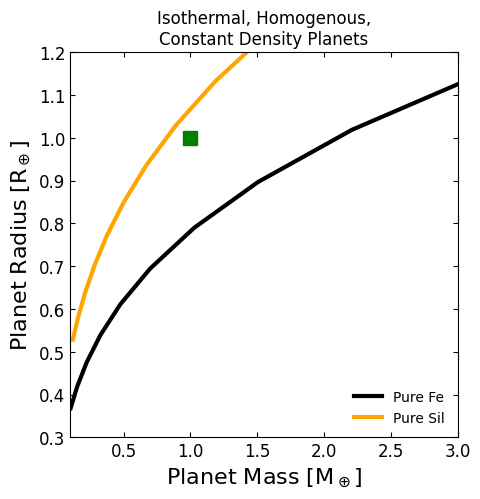

In [3]:
plt.figure(figsize=(5, 5))
plt.plot(mp_fe, rp_fe, 'k', label='Pure Fe', lw=3)
plt.plot(mp_sil, rp_sil, 'orange', label='Pure Sil', lw=3)
plt.plot(1.0, 1.0, 'gs', markersize=10)  # Earth

plt.xlim(0.1, 3)
plt.ylim(0.3, 1.2)
plt.tick_params(which='both', direction='in', labelsize=12, top=True, right=True)
plt.xlabel(r'Planet Mass [M$_\oplus$]', fontsize=16)
plt.ylabel(r'Planet Radius [R$_\oplus$]', fontsize=16)
plt.title('Isothermal, Homogenous,\nConstant Density Planets', loc='center', horizontalalignment='center')

try:
    from labellines import labelLines
    labelLines(fontsize=12)
except:
    plt.legend(loc='lower right', fontsize=10, frameon=False)

plt.show()
